# Zerobond yields from Overnight Index Swaps

In [1]:
# import the used libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import QuantLib as ql
import BootStrapping as bs
import MarketData as md
import ReadExcel
import  math
import openpyxl 
import re
%matplotlib inline

In [7]:
# Setting evaluation date
today = ql.Date.todaysDate()
today = ql.TARGET().adjust(today,ql.Following)
ql.Settings.instance().setEvaluationDate(today)

# Market quotes

In [8]:
mc = md.MarketConventions()
mdata = md.getMarketData("CurvesFromBB\EUR.OIS.xlsx",'Bcurve',['Term','InstType','InstDes','Mid','Frequency','DayCount'])

Could not parse FUTURE Term: 10F
Could not parse FUTURE Term: 11F
Could not parse FUTURE Term: 12F
Could not parse FUTURE Term: 13F
Could not parse FUTURE Term: 14F
Could not parse FUTURE Term: 15F
Could not parse FUTURE Term: 16F
Could not parse FUTURE Term: 17F
Could not parse FUTURE Term: 18F
Could not parse FUTURE Term: 19F
Could not parse FUTURE Term: 20F
Could not parse FUTURE Term: 21F
Could not parse FUTURE Term: 22F
Could not parse FUTURE Term: 23F
Could not parse FUTURE Term: 24F
Could not parse SERIAL_FUTURE Term: 1SF
Could not parse SERIAL_FUTURE Term: 2SF
Could not parse SERIAL_FUTURE Term: 3SF
Could not parse SERIAL_FUTURE Term: 4SF
Could not parse SERIAL_FUTURE Term: 5SF
Could not parse SERIAL_FUTURE Term: 6SF
Could not parse SERIAL_FUTURE Term: 7SF
Could not parse SERIAL_FUTURE Term: 8SF
Could not parse SERIAL_FUTURE Term: 9SF
Could not parse SERIAL_FUTURE Term: 10SF
Could not parse SERIAL_FUTURE Term: 11SF
Could not parse SERIAL_FUTURE Term: 12SF
Could not parse SERIAL

c:\Users\fhoefer\source\repos\fnotebooks\QuantLib\MarketData.py:108: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  maturity = pd.Series([ql.Period(quote.numTimeUnits,quote.timeUnit) for quote in quotes], name='Maturity')
c:\Users\fhoefer\source\repos\fnotebooks\QuantLib\MarketData.py:109: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rate = pd.Series([quote.rate for quote in quotes], name='Rate')


In [22]:
mdata.depoQuotesDF['YearFrac'] = md.get_year_frac(today,mdata.depoQuotesDF['Maturity'],ql.ModifiedFollowing)
mdata.depoQuotesDF

,Maturity,Rate,YearFrac
0,1D,-0.00057,0.002778


In [23]:
mdata.oiSwapQuotesDF['YearFrac'] = md.get_year_frac(today,mdata.oiSwapQuotesDF['Maturity'],ql.ModifiedFollowing)
mdata.oiSwapQuotesDF

,Maturity,Rate,YearFrac
0,1W,-0.000560,0.019444
1,2W,-0.000558,0.038889
2,1M,-0.000630,0.088889
3,2M,-0.000730,0.169444
4,3M,-0.000810,0.252778
5,4M,-0.000870,0.341667
6,5M,-0.000930,0.425000
7,6M,-0.001000,0.505556
8,7M,-0.001040,0.594444
9,8M,-0.001080,0.675000


<Axes: xlabel='YearFrac'>

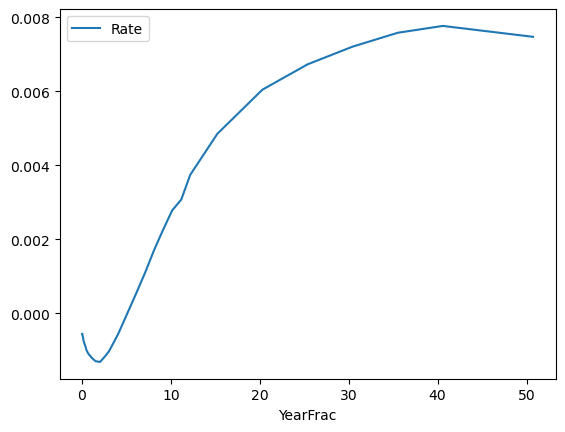

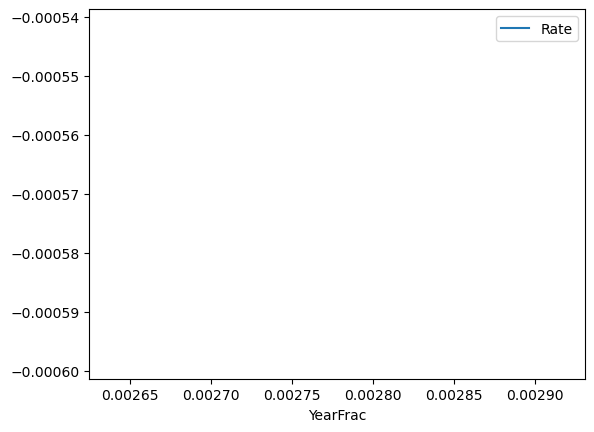

In [25]:
mdata.oiSwapQuotesDF[['YearFrac','Rate']].set_index('YearFrac').plot()
mdata.depoQuotesDF[['YearFrac','Rate']].set_index('YearFrac').plot()

# Bootstrap zero yields from depo and OISwap

In [41]:
oisZeroYields = bs.BootstrapOIS(mdata,mc)
discountTermStructure = ql.RelinkableYieldTermStructureHandle()
discountTermStructure.linkTo(oisZeroYields)
forecastTermStructure = ql.RelinkableYieldTermStructureHandle()
forecastTermStructure.linkTo(oisZeroYields)
# swaps to be priced

swapEngine = ql.DiscountingSwapEngine(discountTermStructure)
def priceOISwap(numTermUnits,termUnit,index,mc):
    nominal = 1000000
    settlementDate = mc.calendar.advance(ql.Settings.instance().evaluationDate,mc.settlementDays,
                                        ql.Days,mc.floatingEoniaConvention)
    maturity = mc.calendar.advance(settlementDate,numTermUnits,termUnit,mc.fixedEoniaConvention)
    
  
    fixedLegAdjustment = mc.fixedEoniaConvention
    fixedLegDayCounter = mc.fixedEoniaDayCount
    fixedLegTenor = ql.Period(1,ql.Years)
    fixedRate = 0.0
  
    spread = 0.0    
    floatingLegAdjustment = mc.floatingEoniaConvention
    floatingLegDayCounter = mc.floatingEoniaDayCount
    floatingLegTenor = ql.Period(1,ql.Years)
   
    fixedSchedule = ql.Schedule(settlementDate, maturity,
                             fixedLegTenor, mc.calendar,
                             fixedLegAdjustment, fixedLegAdjustment,
                             ql.DateGeneration.Forward, False)
    floatingSchedule = ql.Schedule(settlementDate, maturity,
                                floatingLegTenor, mc.calendar,
                                floatingLegAdjustment, floatingLegAdjustment,
                                ql.DateGeneration.Forward, False)

    spot = ql.VanillaSwap(ql.VanillaSwap.Payer, nominal,
                       fixedSchedule, fixedRate, fixedLegDayCounter,
                       floatingSchedule, index, spread,
                       floatingLegDayCounter)
    spot.setPricingEngine(swapEngine)
    return spot.NPV(),spot.fairRate(),spot.fairSpread()




In [42]:
oindex = ql.Eonia(forecastTermStructure)
for item in sorted (mdata.oiSwapQuotes, key = lambda item : ql.Period(item.numTimeUnits,item.timeUnit)):
    print("Market: " + md.printOISwapDatum(item,4)
    + ";Model: " + md.formatRate(priceOISwap(item.numTimeUnits,item.timeUnit,oindex,mc)[1],4)
    + ";Error: " + md.formatRate(item.rate-priceOISwap(item.numTimeUnits,item.timeUnit,oindex,mc)[1],4))

Market: Maturity: 1W	Quoted Rate:-0.0560 %;Model: -0.0560 %;Error: 0.0000 %
Market: Maturity: 2W	Quoted Rate:-0.0558 %;Model: -0.0557 %;Error: -0.0000 %
Market: Maturity: 1M	Quoted Rate:-0.0630 %;Model: -0.0630 %;Error: -0.0000 %
Market: Maturity: 2M	Quoted Rate:-0.0730 %;Model: -0.0730 %;Error: 0.0000 %
Market: Maturity: 3M	Quoted Rate:-0.0810 %;Model: -0.0810 %;Error: -0.0000 %
Market: Maturity: 4M	Quoted Rate:-0.0870 %;Model: -0.0870 %;Error: 0.0000 %
Market: Maturity: 5M	Quoted Rate:-0.0930 %;Model: -0.0930 %;Error: 0.0000 %
Market: Maturity: 6M	Quoted Rate:-0.1000 %;Model: -0.1000 %;Error: -0.0000 %
Market: Maturity: 7M	Quoted Rate:-0.1040 %;Model: -0.1040 %;Error: -0.0000 %
Market: Maturity: 8M	Quoted Rate:-0.1080 %;Model: -0.1080 %;Error: 0.0000 %
Market: Maturity: 9M	Quoted Rate:-0.1110 %;Model: -0.1110 %;Error: -0.0000 %
Market: Maturity: 10M	Quoted Rate:-0.1140 %;Model: -0.1140 %;Error: -0.0000 %
Market: Maturity: 11M	Quoted Rate:-0.1150 %;Model: -0.1150 %;Error: -0.0000 %
Ma

C:\Users\fhoefer\AppData\Local\Temp\ipykernel_8400\786857171.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(yearFracsOIS, [priceOISwap(item.numTimeUnits,item.timeUnit,oindex,mc)[1] for item in mdata.oiSwapQuotes],'k', label='OISwap Model Par Rate',color ='red')
C:\Users\fhoefer\AppData\Local\Temp\ipykernel_8400\786857171.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(yearFracsOIS, [- math.log(oisZeroYields.discount(yf, True))/yf for yf in yearFracsOIS] ,'k', label='OISwap Yield Curve',color ='blue')


Text(0.5, 1.0, ' ')

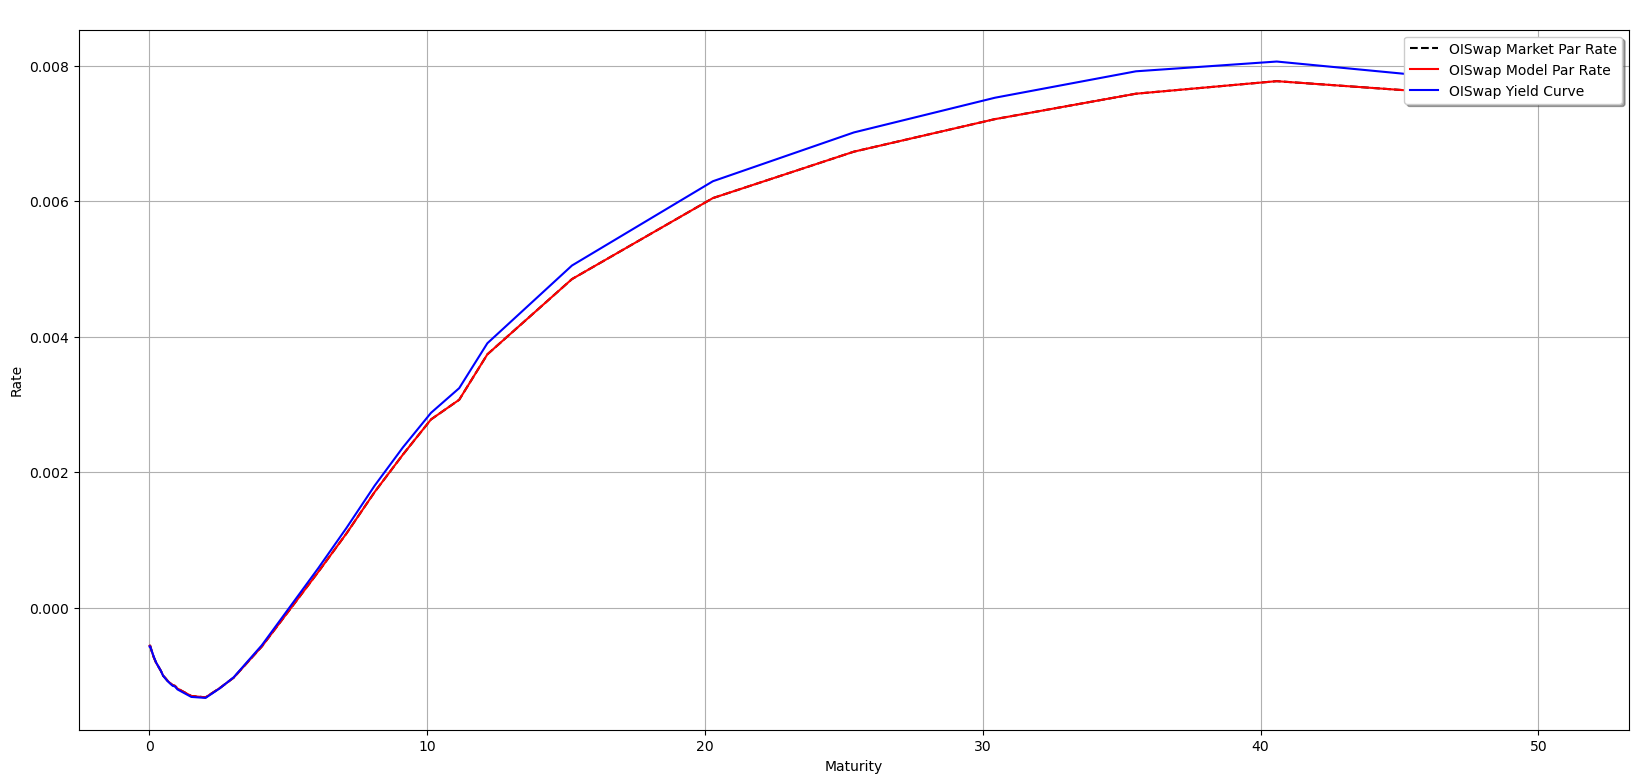

In [44]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(211)
ax.grid(True)

yearFracsOIS = [ql.Actual360().yearFraction(today,mat) 
             for mat in [ ql.TARGET().adjust(today + x, ql.Following) 
             for x in [ql.Period(item.numTimeUnits,item.timeUnit) 
             for item in mdata.oiSwapQuotes]]]

ax.plot(yearFracsOIS, [item.rate for item in mdata.oiSwapQuotes],'k--', label='OISwap Market Par Rate')
ax.plot(yearFracsOIS, [priceOISwap(item.numTimeUnits,item.timeUnit,oindex,mc)[1] for item in mdata.oiSwapQuotes],'k', label='OISwap Model Par Rate',color ='red')
ax.plot(yearFracsOIS, [- math.log(oisZeroYields.discount(yf, True))/yf for yf in yearFracsOIS] ,'k', label='OISwap Yield Curve',color ='blue')
ax.set_xlabel('Maturity') 
ax.set_ylabel('Rate')
legend = ax.legend(loc='upper right', shadow=True)
ax.set_title(" ", fontdict=None, loc=u'center')

In [45]:
yearFracsOIS = [ql.Actual360().yearFraction(today,mat) 
             for mat in [ ql.TARGET().adjust(today + x, ql.Following) 
             for x in [ql.Period(item.numTimeUnits,item.timeUnit) 
             for item in mdata.oiSwapQuotes]]]


wb = openpyxl.load_workbook("MarketData\CurvesFromBB\EUR.OIS.xlsx")
ws = wb.get_sheet_by_name('BView DC (linear_s)')
bblist = ReadExcel.get_list_from_cols(['Term','Df.Mid'],ws) 
bbzeroyield = []

for item in bblist:      
            numSettlementDays =0
            matchResult = re.match("([0-9]{1,2}) ([a-zA-Z][a-zA-Z])", item['Term'], flags=0)
            if(matchResult):
                timeUnit = md.map_BBtenor_to_quantlib(matchResult.group(2))
                numTimeUnits = int(matchResult.group(1))
                rate = item['Df.Mid']*100
                bbzeroyield.append(md.Datum(numSettlementDays,timeUnit,numTimeUnits,rate/100))
            else:
                print("Could not parse " + item['InstType'] + ' ' + 'Term' + ": " +item['Term'] )

yfData =[]
dfData=[]
error =[]
for item in sorted (mdata.oiSwapQuotes, key = lambda item : ql.Period(item.numTimeUnits,item.timeUnit)):
       term = md.printOISwapDatum(item,4)
       yf = ql.Actual360().yearFraction(today,ql.TARGET().adjust(today + ql.Period(item.numTimeUnits,item.timeUnit), ql.Following)) 
       yfData.append(yf)
       df = [bbitem.rate for bbitem in bbzeroyield if ((item.numTimeUnits == bbitem.numTimeUnits)&(item.timeUnit == bbitem.timeUnit))][0]
       dfData.append(df)
       err = df - oisZeroYields.discount(yf, True)
       error.append(err)
       print("Market: " + term + ':  ')
       print("   Discount Factor:    " + str(oisZeroYields.discount(yf, True)))       
       print("   BB Discount Factor: " + str(df))
       print("   Error: " + str(err))

FileNotFoundError: [Errno 2] No such file or directory: 'MarketData\\CurvesFromBB\\EUR.OIS.xlsx'

In [ ]:
fig2 = plt.figure(figsize=(20,20))
ax2 = fig2.add_subplot(211)
ax2.grid(True)

yearFracsOIS = [ql.Actual360().yearFraction(today,mat) 
             for mat in [ ql.TARGET().adjust(today + x, ql.Following) 
             for x in [ql.Period(item.numTimeUnits,item.timeUnit) 
             for item in mdata.oiSwapQuotes]]]

ax2.plot(yfData, dfData,'k--', label='BB Discount Factors', color ='green')
ax2.plot(yfData, [oisZeroYields.discount(yf, True) for yf in yfData] ,'k', label='QuantLib Discount Factors',color ='blue')
ax2.set_xlabel('Maturity') 
ax2.set_ylabel('Rate')
legend = ax2.legend(loc='upper right', shadow=True)
ax2.set_title(" ", fontdict=None, loc=u'center')